In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages  # 引入PDF保存模块
from scipy.signal import find_peaks
import pyvista as pv  

## 1 曲率和扭率

### 1.1 曲率扭率可视化(V-modeler)

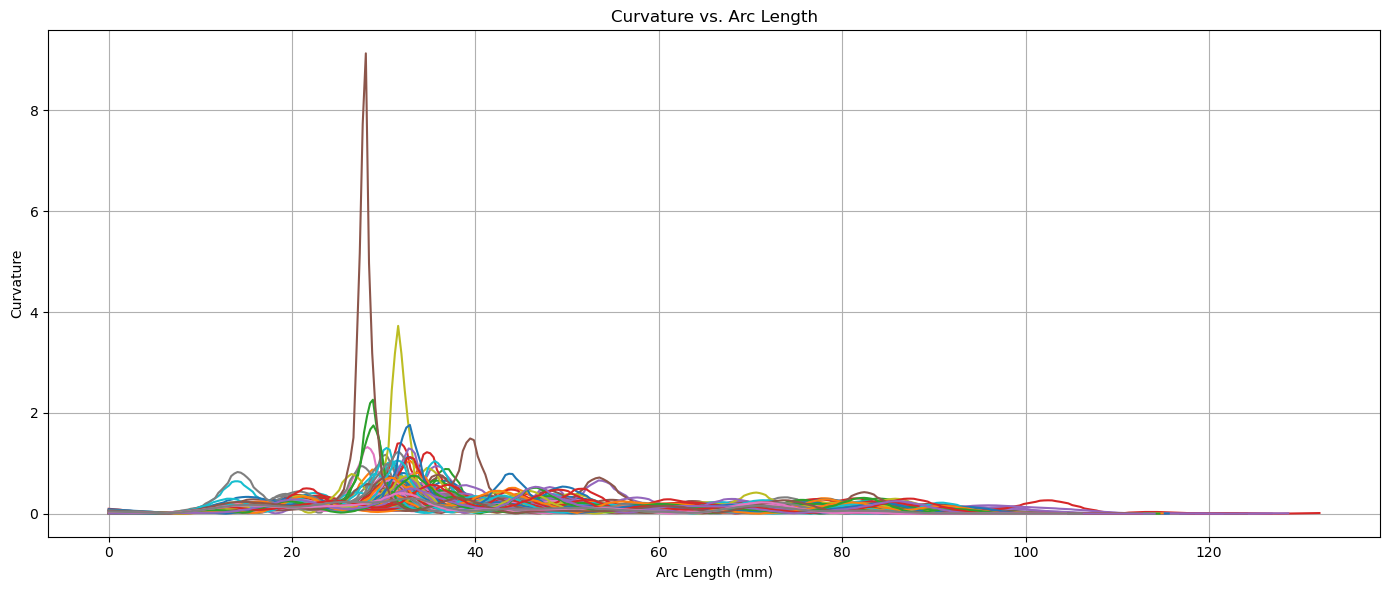

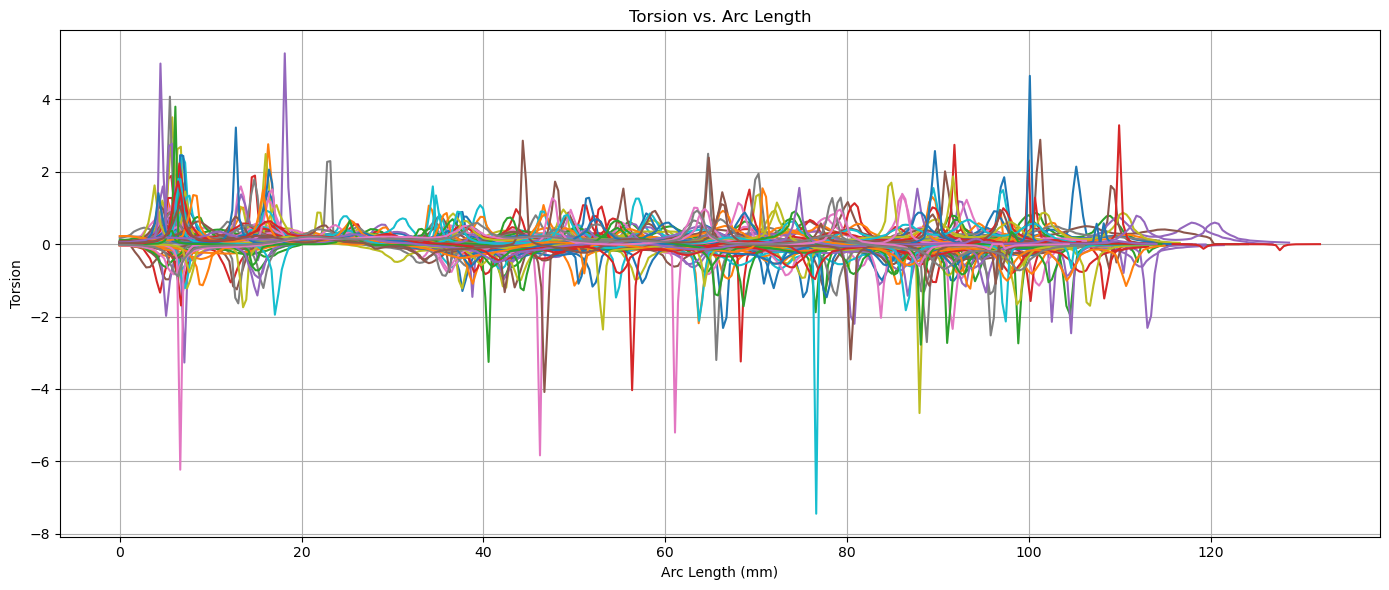

In [10]:
def load_ply_with_curvature_torsion(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    header_end_idx = next(i for i, line in enumerate(lines) if 'end_header' in line)
    vertex_count = 0
    for line in lines:
        if line.startswith("element vertex"):
            vertex_count = int(line.split()[-1])
            break

    vertex_lines = lines[header_end_idx + 1 : header_end_idx + 1 + vertex_count]
    data = [list(map(float, line.strip().split())) for line in vertex_lines]
    df = pd.DataFrame(data, columns=["x", "y", "z", "label", "attribute", "radius", "curvature", "torsion"])
    
    coords = df[["x", "y", "z"]].values
    segment_lengths = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    arc_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)
    df["arc_length"] = arc_length

    return df

# 获取所有 .ply 文件
directory = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\6_Centerline(V-modeler)"
ply_files = [f for f in os.listdir(directory) if f.endswith(".ply")]

# 初始化图
plt.figure(figsize=(14, 6))
plt.subplot(1, 1, 1)
for fname in ply_files:
    df = load_ply_with_curvature_torsion(os.path.join(directory, fname))
    plt.plot(df["arc_length"], df["curvature"], label=f"{fname}")
plt.xlabel("Arc Length (mm)")
plt.ylabel("Curvature")
plt.title("Curvature vs. Arc Length")
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
for fname in ply_files:
    df = load_ply_with_curvature_torsion(os.path.join(directory, fname))
    plt.plot(df["arc_length"], df["torsion"], label=f"{fname}")
plt.xlabel("Arc Length (mm)")
plt.ylabel("Torsion")
plt.title("Torsion vs. Arc Length")
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 1.2 可视化保存

In [11]:


def load_ply_with_curvature_torsion(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    header_end_idx = next(i for i, line in enumerate(lines) if 'end_header' in line)
    vertex_count = 0
    for line in lines:
        if line.startswith("element vertex"):
            vertex_count = int(line.split()[-1])
            break

    vertex_lines = lines[header_end_idx + 1 : header_end_idx + 1 + vertex_count]
    data = [list(map(float, line.strip().split())) for line in vertex_lines]
    df = pd.DataFrame(data, columns=["x", "y", "z", "label", "attribute", "radius", "curvature", "torsion"])

    coords = df[["x", "y", "z"]].values
    segment_lengths = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    cumulative_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)
    df["line_length"] = cumulative_length

    return df

# === 输入与输出路径 ===
directory = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\6_Centerline(V-modeler)"
output_pdf = r"D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\1_Curvature and Torsion(total)\1_curvature_Torsion_total.pdf"

# 如果输出文件夹不存在就创建
os.makedirs(os.path.dirname(output_pdf), exist_ok=True)

ply_files = [f for f in os.listdir(directory) if f.endswith(".ply")]
num_files = len(ply_files)

# === 保存到指定路径的 PDF ===
with PdfPages(output_pdf) as pdf:
    fig, axes = plt.subplots(nrows=num_files, ncols=2, figsize=(14, 2.5 * num_files), sharex=False)

    if num_files == 1:
        axes = np.array([axes])

    for i, fname in enumerate(ply_files):
        df = load_ply_with_curvature_torsion(os.path.join(directory, fname))

        # 曲率
        axes[i, 0].plot(df["line_length"], df["curvature"], color='blue')
        axes[i, 0].set_title(f"{fname} - Curvature")
        axes[i, 0].set_xlabel("Centerline Length (mm)")
        axes[i, 0].set_ylabel("Curvature")
        axes[i, 0].grid(True)

        # 扭率
        axes[i, 1].plot(df["line_length"], df["torsion"], color='green')
        axes[i, 1].set_title(f"{fname} - Torsion")
        axes[i, 1].set_xlabel("Centerline Length (mm)")
        axes[i, 1].set_ylabel("Torsion")
        axes[i, 1].grid(True)

    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

#print(f"✅ 已保存所有图为 PDF 文件：{output_pdf}")


### 1.3 识别曲率峰值并剪裁siphon（一般）

In [17]:
def load_ply_with_curvature_torsion(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
    header_end_idx = next(i for i, line in enumerate(lines) if "end_header" in line)
    vertex_count = 0
    for line in lines:
        if line.startswith("element vertex"):
            vertex_count = int(line.split()[-1])
            break
    vertex_lines = lines[header_end_idx + 1 : header_end_idx + 1 + vertex_count]
    data = [list(map(float, line.strip().split())) for line in vertex_lines]
    df = pd.DataFrame(data, columns=["x", "y", "z", "label", "attribute", "radius", "curvature", "torsion"])
    coords = df[["x", "y", "z"]].values
    segment_lengths = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    cumulative_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)
    df["centerline_length"] = cumulative_length
    return df

def analyze_ply_for_subplot(filepath):
    df = load_ply_with_curvature_torsion(filepath)
    curvatures = df["curvature"].values
    torsions = df["torsion"].values
    lengths = df["centerline_length"].values
    peaks, _ = find_peaks(curvatures)

    if len(peaks) < 1:
        return None

    max_idx = max(peaks, key=lambda i: curvatures[i])
    peak_list = list(peaks)
    max_pos = peak_list.index(max_idx)

    next_idx = peak_list[max_pos + 1] if max_pos < len(peak_list) - 1 else None
    next_next_idx = peak_list[max_pos + 2] if max_pos + 2 < len(peak_list) else None

    # 红线 valley_prev_idx：从最大峰向左，直到不再下降
    valley_prev_idx = max_idx
    i = max_idx
    while i > 1 and curvatures[i - 1] < curvatures[i]:
        i -= 1
    valley_prev_idx = i

    # 黑线 valley_black_idx：max_idx 与 next_idx 之间最低点
    valley_black_idx = None
    if next_idx is not None:
        start, end = sorted([max_idx, next_idx])
        valley_black_idx = start + np.argmin(curvatures[start:end + 1])

    # 黄线 valley_yellow_idx：next_idx 与 next_next_idx 之间最低点
    valley_yellow_idx = None
    if next_idx is not None and next_next_idx is not None:
        start, end = sorted([next_idx, next_next_idx])
        valley_yellow_idx = start + np.argmin(curvatures[start:end + 1])

    return {
        "name": os.path.basename(filepath),
        "path": filepath,
        "lengths": lengths,
        "curvatures": curvatures,
        "torsions": torsions,
        "max_idx": max_idx,
        "next_idx": next_idx,
        "valley_prev_idx": valley_prev_idx,
        "valley_black_idx": valley_black_idx,
        "valley_yellow_idx": valley_yellow_idx
    }

def export_clipped_vtk(df, start_idx, end_idx, output_path):
    clipped = df.iloc[start_idx:end_idx + 1].reset_index(drop=True)
    if len(clipped) < 2:
        return
    points = clipped[["x", "y", "z"]].values
    lines = np.hstack([[len(points), *range(len(points))]])

    poly = pv.PolyData()
    poly.points = points
    poly.lines = lines
    poly["MaximumInscribedSphereRadius"] = clipped["radius"].values
    poly["curvature"] = clipped["curvature"].values
    poly["torsion"] = clipped["torsion"].values
    poly.save(output_path)

# === 主程序 ===
if __name__ == "__main__":
    # === 指定输入/输出路径 ===
    input_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\6_Centerline(V-modeler)"
    pdf_dir = r"D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\1_Curvature and Torsion(total)"
    vtk_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\7_Centerline_Siphon"

    os.makedirs(pdf_dir, exist_ok=True)
    os.makedirs(vtk_dir, exist_ok=True)

    exclude_files = {
        "BG0019_L.ply", "BG0019_R.ply", "BG0011_L.ply",
        "BH0005_L.ply", "BH0016_L.ply", "BH0039_R.ply"
    }

    ply_files = [
        os.path.join(input_dir, f)
        for f in os.listdir(input_dir)
        if f.endswith(".ply") and f not in exclude_files
    ]
    results = [analyze_ply_for_subplot(f) for f in ply_files]
    results = [r for r in results if r is not None]

    # === PDF 图像绘制与保存 ===
    n = len(results)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(14, 2.8 * n))
    if n == 1:
        axes = np.array([axes])

    for i, result in enumerate(results):
        ax0, ax1 = axes[i]
        ax0.plot(result["lengths"], result["curvatures"], color='blue')
        ax0.scatter(result["lengths"][result["max_idx"]], result["curvatures"][result["max_idx"]], color='red', label='Max')
        if result["next_idx"] is not None:
            ax0.scatter(result["lengths"][result["next_idx"]], result["curvatures"][result["next_idx"]], color='orange', label='Next')
        if result["valley_prev_idx"] is not None:
            ax0.axvline(result["lengths"][result["valley_prev_idx"]], color='red', linestyle='-')
        if result["valley_black_idx"] is not None:
            ax0.axvline(result["lengths"][result["valley_black_idx"]], color='black', linestyle='--')
        if result["valley_yellow_idx"] is not None:
            ax0.axvline(result["lengths"][result["valley_yellow_idx"]], color='orange', linestyle='--')
        ax0.set_title(f"{result['name']} - Curvature")
        ax0.set_xlabel("Centerline Length (mm)")
        ax0.set_ylabel("Curvature")
        ax0.grid(True)
        ax0.legend()

        ax1.plot(result["lengths"], result["torsions"], color='green')
        if result["valley_prev_idx"] is not None:
            ax1.axvline(result["lengths"][result["valley_prev_idx"]], color='red', linestyle='-')
        if result["valley_black_idx"] is not None:
            ax1.axvline(result["lengths"][result["valley_black_idx"]], color='black', linestyle='--')
        if result["valley_yellow_idx"] is not None:
            ax1.axvline(result["lengths"][result["valley_yellow_idx"]], color='orange', linestyle='--')
        ax1.set_title(f"{result['name']} - Torsion")
        ax1.set_xlabel("Centerline Length (mm)")
        ax1.set_ylabel("Torsion")
        ax1.grid(True)

    plt.tight_layout()
    pdf_path = os.path.join(pdf_dir, "2_curvature_torsion_with_peck(normal).pdf")
    plt.savefig(pdf_path, format="pdf", bbox_inches='tight')
    plt.close()
    #print(f"✅ 图像保存完成：{pdf_path}")

    # === 裁剪并导出 VTK ===
    for result in results:
        start = result["valley_prev_idx"]
        end = result["valley_yellow_idx"]
        if start is not None and end is not None and start < end:
            df_original = load_ply_with_curvature_torsion(result["path"])
            output_name = os.path.splitext(result["name"])[0] + "_siphon.vtk"
            output_path = os.path.join(vtk_dir, output_name)
            export_clipped_vtk(df_original, start, end, output_path)
            #print(f"🧩 导出 VTK：{output_name}")


### 1.4 识别曲率峰值并剪裁siphon（特殊）
        "BG0019_L.ply", "BG0019_R.ply", "BG0011_L.ply",
        "BH0005_L.ply", "BH0016_L.ply", "BH0039_R.ply"

In [19]:
def load_ply_with_curvature_torsion(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
    header_end_idx = next(i for i, line in enumerate(lines) if "end_header" in line)
    vertex_count = 0
    for line in lines:
        if line.startswith("element vertex"):
            vertex_count = int(line.split()[-1])
            break
    vertex_lines = lines[header_end_idx + 1 : header_end_idx + 1 + vertex_count]
    data = [list(map(float, line.strip().split())) for line in vertex_lines]
    df = pd.DataFrame(data, columns=["x", "y", "z", "label", "attribute", "radius", "curvature", "torsion"])
    coords = df[["x", "y", "z"]].values
    segment_lengths = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    cumulative_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)
    df["centerline_length"] = cumulative_length
    return df

def export_clipped_vtk(df, start_idx, end_idx, output_path):
    clipped = df.iloc[start_idx:end_idx + 1].reset_index(drop=True)
    if len(clipped) < 2:
        return
    points = clipped[["x", "y", "z"]].values
    lines = np.hstack([[len(points), *range(len(points))]])

    poly = pv.PolyData()
    poly.points = points
    poly.lines = lines
    poly["MaximumInscribedSphereRadius"] = clipped["radius"].values
    poly["curvature"] = clipped["curvature"].values
    poly["torsion"] = clipped["torsion"].values
    poly.save(output_path)

def analyze_special_ply(filepath):
    df = load_ply_with_curvature_torsion(filepath)
    curvatures = df["curvature"].values
    lengths = df["centerline_length"].values

    peaks, _ = find_peaks(curvatures)
    if len(peaks) < 2:
        return None

    sorted_peaks = sorted(peaks, key=lambda i: curvatures[i], reverse=True)
    second_peak = sorted_peaks[1]
    next_peak = sorted([p for p in peaks if p > second_peak], key=lambda i: i)[0] if any(p > second_peak for p in peaks) else None

    red_line = second_peak
    i = second_peak
    while i > 1 and curvatures[i - 1] < curvatures[i]:
        i -= 1
    red_line = i

    yellow_line = None
    if next_peak is not None:
        i = next_peak
        while i < len(curvatures) - 1 and curvatures[i + 1] < curvatures[i]:
            i += 1
        yellow_line = i

    black_line = None
    if next_peak is not None:
        black_line = second_peak + np.argmin(curvatures[second_peak:next_peak + 1])

    return {
        "name": os.path.basename(filepath),
        "lengths": lengths,
        "curvatures": curvatures,
        "df": df,
        "second_peak": second_peak,
        "next_peak": next_peak,
        "red_line": red_line,
        "black_line": black_line,
        "yellow_line": yellow_line
    }

# === 主程序 ===
if __name__ == "__main__":
    # === 指定输入输出路径 ===
    input_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\6_Centerline(V-modeler)"
    pdf_dir = r"D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\1_Curvature and Torsion(total)"
    vtk_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\7_Centerline_Siphon"

    os.makedirs(pdf_dir, exist_ok=True)
    os.makedirs(vtk_dir, exist_ok=True)

    special_files = {
        "BG0019_L.ply", "BG0019_R.ply", "BG0011_L.ply",
        "BH0005_L.ply", "BH0016_L.ply", "BH0039_R.ply"
    }

    results = []
    for fname in special_files:
        input_path = os.path.join(input_dir, fname)
        if os.path.exists(input_path):
            res = analyze_special_ply(input_path)
            if res:
                results.append(res)

    fig, axes = plt.subplots(nrows=len(results), figsize=(12, 4 * len(results)))
    if len(results) == 1:
        axes = [axes]

    for ax, result in zip(axes, results):
        ax.plot(result["lengths"], result["curvatures"], color='blue', label='Curvature')
        ax.scatter(result["lengths"][result["second_peak"]], result["curvatures"][result["second_peak"]], color='red', label='2nd Peak')
        if result["next_peak"]:
            ax.scatter(result["lengths"][result["next_peak"]], result["curvatures"][result["next_peak"]], color='orange', label='Next Peak')
        if result["red_line"]:
            ax.axvline(result["lengths"][result["red_line"]], color='red', linestyle='--', label='Red Line')
        if result["black_line"]:
            ax.axvline(result["lengths"][result["black_line"]], color='black', linestyle='--', label='Black Line')
        if result["yellow_line"]:
            ax.axvline(result["lengths"][result["yellow_line"]], color='orange', linestyle='--', label='Yellow Line')

        ax.set_title(result["name"])
        ax.set_xlabel("Centerline Length (mm)")
        ax.set_ylabel("Curvature")
        ax.grid(True)
        ax.legend()

        # 保存 VTK
        start = result["red_line"]
        end = result["yellow_line"]
        if start is not None and end is not None and start < end:
            output_name = os.path.splitext(result["name"])[0] + "_siphon.vtk"
            output_path = os.path.join(vtk_dir, output_name)
            export_clipped_vtk(result["df"], start, end, output_path)
            #print(f"🧩 导出 VTK：{output_name}")

    plt.tight_layout()
    pdf_path = os.path.join(pdf_dir, "3_curvature_torsion_with_peck(special).pdf")
    plt.savefig(pdf_path)
    plt.close()
    #print(f"✅ 图像保存完成：{pdf_path}")


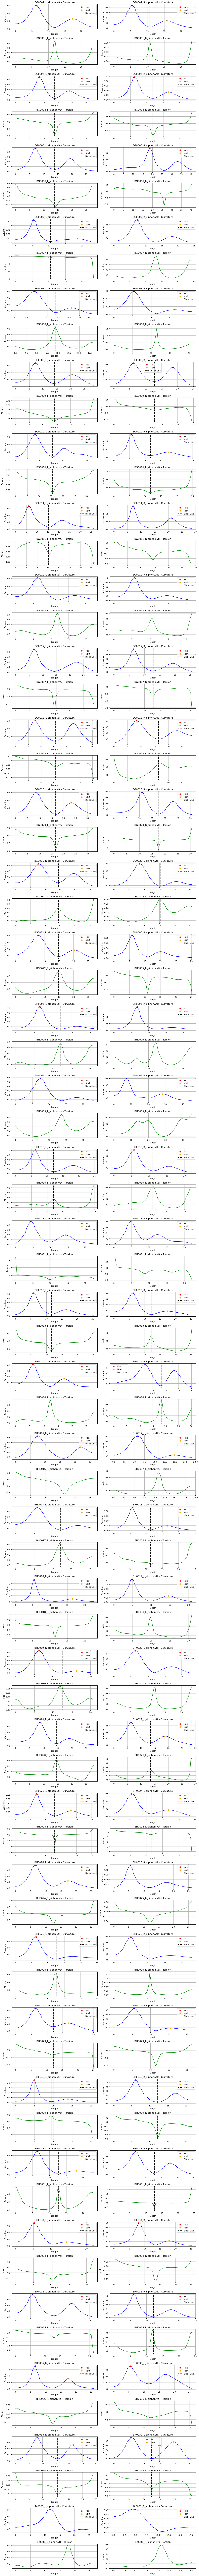

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
from scipy.signal import find_peaks

def load_vtk_with_curvature_torsion(filepath):
    mesh = pv.read(filepath)
    points = mesh.points
    curvature = mesh.point_data.get("curvature")
    torsion = mesh.point_data.get("torsion")

    if curvature is None or torsion is None:
        return None

    segment_lengths = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumulative_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)

    return {
        "name": os.path.basename(filepath),
        "lengths": cumulative_length,
        "curvature": curvature,
        "torsion": torsion
    }

def analyze_peaks(curvature):
    peaks, _ = find_peaks(curvature)
    if len(peaks) < 1:
        return None

    max_idx = max(peaks, key=lambda i: curvature[i])
    peak_list = list(peaks)
    max_pos = peak_list.index(max_idx)

    next_idx = peak_list[max_pos + 1] if max_pos + 1 < len(peak_list) else None
    next_next_idx = peak_list[max_pos + 2] if max_pos + 2 < len(peak_list) else None

    valley_black_idx = None
    if next_idx is not None:
        start, end = sorted([max_idx, next_idx])
        valley_black_idx = start + np.argmin(curvature[start:end+1])

    valley_yellow_idx = None
    if next_idx is not None and next_next_idx is not None:
        start, end = sorted([next_idx, next_next_idx])
        valley_yellow_idx = start + np.argmin(curvature[start:end+1])

    return {
        "max_idx": max_idx,
        "next_idx": next_idx,
        "valley_black_idx": valley_black_idx,
        "valley_yellow_idx": valley_yellow_idx
    }

# 设置目录
vtk_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\siphon"
vtk_files = sorted([f for f in os.listdir(vtk_dir) if f.endswith(".vtk")])
results = []

for f in vtk_files:
    data = load_vtk_with_curvature_torsion(os.path.join(vtk_dir, f))
    if data is None:
        continue
    peaks_info = analyze_peaks(data["curvature"])
    if peaks_info:
        data.update(peaks_info)
        results.append(data)

# 图形设置
num_files = len(results)
num_cols = 2
num_rows = int(np.ceil(num_files / num_cols))
fig, axes = plt.subplots(nrows=num_rows * 2, ncols=2, figsize=(14, 2.5 * num_rows * 2))
axes = np.array(axes)

if axes.ndim != 2:
    axes = axes.reshape((2, 2))

for idx, result in enumerate(results):
    col = idx % 2
    row = (idx // 2) * 2
    ax_curv = axes[row, col]
    ax_tors = axes[row + 1, col]

    x = result["lengths"]
    y1 = result["curvature"]
    y2 = result["torsion"]

    ax_curv.plot(x, y1, color='blue')
    ax_curv.set_title(f"{result['name']} - Curvature")
    ax_curv.set_xlabel("Length")
    ax_curv.set_ylabel("Curvature")
    ax_curv.grid(True)

    if "max_idx" in result:
        ax_curv.scatter(x[result["max_idx"]], y1[result["max_idx"]], color='red', label='Max')
    if result.get("next_idx") is not None:
        ax_curv.scatter(x[result["next_idx"]], y1[result["next_idx"]], color='orange', label='Next')
    if result.get("valley_black_idx") is not None:
        ax_curv.axvline(x[result["valley_black_idx"]], color='black', linestyle='--', label='Black Line')
    if result.get("valley_yellow_idx") is not None:
        ax_curv.axvline(x[result["valley_yellow_idx"]], color='orange', linestyle='--', label='Yellow Line')
    ax_curv.legend()

    ax_tors.plot(x, y2, color='green')
    ax_tors.set_title(f"{result['name']} - Torsion")
    ax_tors.set_xlabel("Length")
    ax_tors.set_ylabel("Torsion")
    ax_tors.grid(True)

    if result.get("valley_black_idx") is not None:
        ax_tors.axvline(x[result["valley_black_idx"]], color='black', linestyle='--')
    if result.get("valley_yellow_idx") is not None:
        ax_tors.axvline(x[result["valley_yellow_idx"]], color='orange', linestyle='--')

plt.tight_layout()
plt.savefig("vtk_curvature_torsion_pairwise_final.pdf", format="pdf", bbox_inches='tight')
plt.show()

# === 追加：保存分析结果为 CSV 文件 ===
csv_rows = []

for result in results:
    row = {
        "name": result["name"],
        "total_length": result["lengths"][-1],
        "curvature_max": result["curvature"][result["max_idx"]] if "max_idx" in result else np.nan,
        "curvature_next": result["curvature"][result["next_idx"]] if result.get("next_idx") is not None else np.nan,
        "distance_max_to_next": (
            result["lengths"][result["next_idx"]] - result["lengths"][result["max_idx"]]
            if result.get("next_idx") is not None else np.nan
        ),
        "torsion_start": result["torsion"][0] if len(result["torsion"]) > 0 else np.nan,
        "torsion_black_line": (
            result["torsion"][result["valley_black_idx"]] if result.get("valley_black_idx") is not None else np.nan
        ),
        "torsion_end": result["torsion"][-1] if len(result["torsion"]) > 0 else np.nan
    }

    csv_rows.append(row)

df_csv = pd.DataFrame(csv_rows)
df_csv.to_csv("curvature_torsion_metrics.csv", index=False, encoding="utf-8-sig")



C:\Users\k\AppData\Local\Temp\ipykernel_11308\991216424.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([df[col].dropna() for col in curvature_cols], labels=curvature_cols)
C:\Users\k\AppData\Local\Temp\ipykernel_11308\991216424.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([df[col].dropna() for col in torsion_cols], labels=torsion_cols)
C:\Users\k\AppData\Local\Temp\ipykernel_11308\991216424.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2, 0].boxplot([df[col].dropna() for col in length_cols], labels=length_cols)
C:\Users\k\AppData\Local\Temp\ipykernel_1130

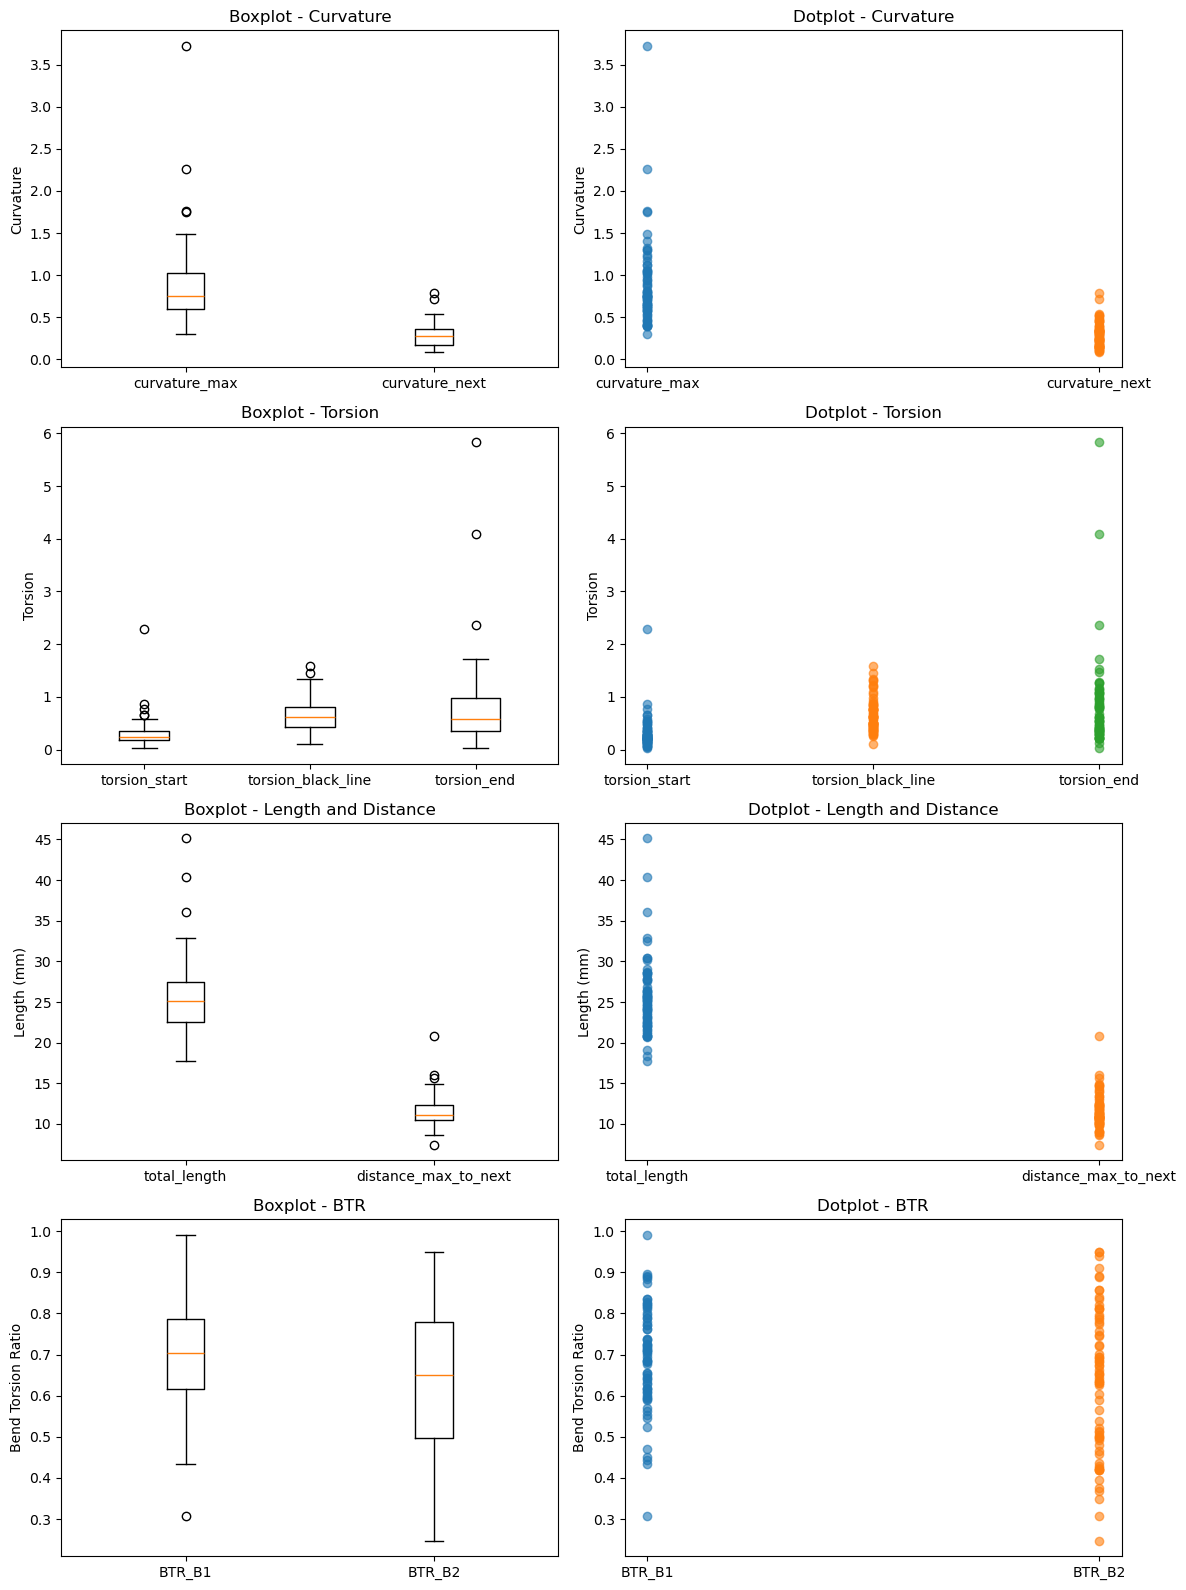

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("curvature_torsion_metrics_BTR.csv")

# 原始变量
curvature_cols = [col for col in ["curvature_max", "curvature_next"] if col in df.columns]
torsion_cols = [col for col in ["torsion_start", "torsion_black_line", "torsion_end"] if col in df.columns]
length_cols = ["total_length", "distance_max_to_next"]
btr_cols = [col for col in ["BTR_B1", "BTR_B2"] if col in df.columns]

# 创建图像（4行2列）
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

# --- 曲率 ---
if curvature_cols:
    axes[0, 0].boxplot([df[col].dropna() for col in curvature_cols], labels=curvature_cols)
    axes[0, 0].set_title("Boxplot - Curvature")
    axes[0, 0].set_ylabel("Curvature")

    for i, col in enumerate(curvature_cols):
        axes[0, 1].scatter([i] * len(df[col]), df[col], label=col, alpha=0.6)
    axes[0, 1].set_xticks(range(len(curvature_cols)))
    axes[0, 1].set_xticklabels(curvature_cols)
    axes[0, 1].set_title("Dotplot - Curvature")
    axes[0, 1].set_ylabel("Curvature")

# --- 扭率 ---
if torsion_cols:
    axes[1, 0].boxplot([df[col].dropna() for col in torsion_cols], labels=torsion_cols)
    axes[1, 0].set_title("Boxplot - Torsion")
    axes[1, 0].set_ylabel("Torsion")

    for i, col in enumerate(torsion_cols):
        axes[1, 1].scatter([i] * len(df[col]), df[col], label=col, alpha=0.6)
    axes[1, 1].set_xticks(range(len(torsion_cols)))
    axes[1, 1].set_xticklabels(torsion_cols)
    axes[1, 1].set_title("Dotplot - Torsion")
    axes[1, 1].set_ylabel("Torsion")

# --- 长度 ---
axes[2, 0].boxplot([df[col].dropna() for col in length_cols], labels=length_cols)
axes[2, 0].set_title("Boxplot - Length and Distance")
axes[2, 0].set_ylabel("Length (mm)")

for i, col in enumerate(length_cols):
    axes[2, 1].scatter([i] * len(df[col]), df[col], label=col, alpha=0.6)
axes[2, 1].set_xticks(range(len(length_cols)))
axes[2, 1].set_xticklabels(length_cols)
axes[2, 1].set_title("Dotplot - Length and Distance")
axes[2, 1].set_ylabel("Length (mm)")

# --- BTR ---
axes[3, 0].boxplot([df[col].dropna() for col in btr_cols], labels=btr_cols)
axes[3, 0].set_title("Boxplot - BTR")
axes[3, 0].set_ylabel("Bend Torsion Ratio")

for i, col in enumerate(btr_cols):
    axes[3, 1].scatter([i] * len(df[col]), df[col], label=col, alpha=0.6)
axes[3, 1].set_xticks(range(len(btr_cols)))
axes[3, 1].set_xticklabels(btr_cols)
axes[3, 1].set_title("Dotplot - BTR")
axes[3, 1].set_ylabel("Bend Torsion Ratio")

plt.tight_layout()
plt.savefig("box_dot_all_metrics_including_btr.pdf", bbox_inches="tight")
plt.show()


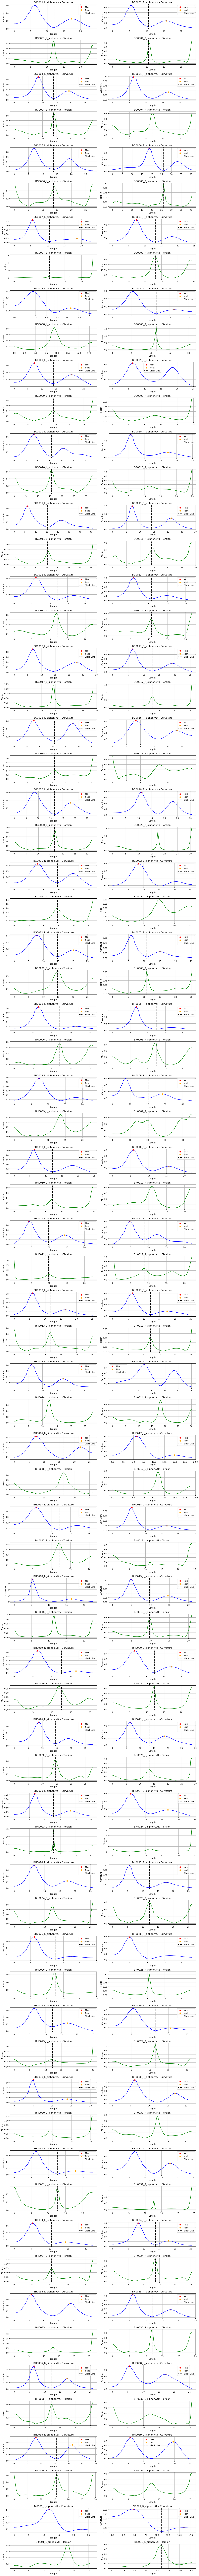

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
from scipy.signal import find_peaks
import pandas as pd

def load_vtk_with_curvature_torsion(filepath):
    mesh = pv.read(filepath)
    points = mesh.points
    curvature = mesh.point_data.get("curvature")
    torsion = mesh.point_data.get("torsion")

    if curvature is None or torsion is None:
        return None

    segment_lengths = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumulative_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)

    return {
        "name": os.path.basename(filepath),
        "lengths": cumulative_length,
        "curvature": curvature,
        "torsion": np.abs(torsion)  # 取绝对值
    }

def analyze_peaks(curvature):
    peaks, _ = find_peaks(curvature)
    if len(peaks) < 1:
        return None

    max_idx = max(peaks, key=lambda i: curvature[i])
    peak_list = list(peaks)
    max_pos = peak_list.index(max_idx)

    next_idx = peak_list[max_pos + 1] if max_pos + 1 < len(peak_list) else None
    next_next_idx = peak_list[max_pos + 2] if max_pos + 2 < len(peak_list) else None

    valley_black_idx = None
    if next_idx is not None:
        start, end = sorted([max_idx, next_idx])
        valley_black_idx = start + np.argmin(curvature[start:end+1])

    valley_yellow_idx = None
    if next_idx is not None and next_next_idx is not None:
        start, end = sorted([next_idx, next_next_idx])
        valley_yellow_idx = start + np.argmin(curvature[start:end+1])

    return {
        "max_idx": max_idx,
        "next_idx": next_idx,
        "valley_black_idx": valley_black_idx,
        "valley_yellow_idx": valley_yellow_idx
    }

def compute_btr(torsion, start_idx, end_idx):
    if end_idx - start_idx < 5:
        return np.nan

    full = torsion[start_idx:end_idx+1]
    total_mean = np.mean(full)

    L = len(full)
    core_start = start_idx + int(L * 0.1)
    core_end = end_idx - int(L * 0.1)
    if core_end <= core_start:
        return np.nan

    core = torsion[core_start:core_end+1]
    core_mean = np.mean(core)

    return core_mean / total_mean if total_mean > 0 else np.nan

# 设置目录
vtk_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\siphon"
vtk_files = sorted([f for f in os.listdir(vtk_dir) if f.endswith(".vtk")])
results = []

for f in vtk_files:
    data = load_vtk_with_curvature_torsion(os.path.join(vtk_dir, f))
    if data is None:
        continue
    peaks_info = analyze_peaks(data["curvature"])
    if peaks_info:
        data.update(peaks_info)
        results.append(data)

# 可视化并计算 BTR
num_files = len(results)
num_cols = 2
num_rows = int(np.ceil(num_files / num_cols))
fig, axes = plt.subplots(nrows=num_rows * 2, ncols=2, figsize=(14, 2.5 * num_rows * 2))
axes = np.array(axes)

if axes.ndim != 2:
    axes = axes.reshape((2, 2))

csv_rows = []

for idx, result in enumerate(results):
    col = idx % 2
    row = (idx // 2) * 2
    ax_curv = axes[row, col]
    ax_tors = axes[row + 1, col]

    x = result["lengths"]
    y1 = result["curvature"]
    y2 = result["torsion"]

    ax_curv.plot(x, y1, color='blue')
    ax_curv.set_title(f"{result['name']} - Curvature")
    ax_curv.set_xlabel("Length")
    ax_curv.set_ylabel("Curvature")
    ax_curv.grid(True) 

    if "max_idx" in result:
        ax_curv.scatter(x[result["max_idx"]], y1[result["max_idx"]], color='red', label='Max')
    if result.get("next_idx") is not None:
        ax_curv.scatter(x[result["next_idx"]], y1[result["next_idx"]], color='orange', label='Next')
    if result.get("valley_black_idx") is not None:
        ax_curv.axvline(x[result["valley_black_idx"]], color='black', linestyle='--', label='Black Line')
    if result.get("valley_yellow_idx") is not None:
        ax_curv.axvline(x[result["valley_yellow_idx"]], color='orange', linestyle='--', label='Yellow Line')
    ax_curv.legend()

    ax_tors.plot(x, y2, color='green')
    ax_tors.set_title(f"{result['name']} - Torsion")
    ax_tors.set_xlabel("Length")
    ax_tors.set_ylabel("Torsion")
    ax_tors.grid(True)

    if result.get("valley_black_idx") is not None:
        ax_tors.axvline(x[result["valley_black_idx"]], color='black', linestyle='--')
    if result.get("valley_yellow_idx") is not None:
        ax_tors.axvline(x[result["valley_yellow_idx"]], color='orange', linestyle='--')

    # === BTR 计算 ===
    tors = y2
    L = len(tors)
    vb = result.get("valley_black_idx")

    btr1 = compute_btr(tors, 0, vb - 1) if vb and vb > 1 else np.nan
    btr2 = compute_btr(tors, vb, L - 1) if vb and vb < L - 1 else np.nan

    csv_rows.append({
        "name": result["name"],
        "total_length": x[-1],
        "curvature_max": y1[result["max_idx"]],
        "curvature_next": y1[result["next_idx"]] if result.get("next_idx") is not None else np.nan,
        "distance_max_to_next": (
            x[result["next_idx"]] - x[result["max_idx"]]
            if result.get("next_idx") is not None else np.nan
        ),
        "torsion_start": y2[0],
        "torsion_black_line": y2[result["valley_black_idx"]] if result.get("valley_black_idx") is not None else np.nan,
        "torsion_end": y2[-1],
        "BTR_B1": btr1,
        "BTR_B2": btr2
    })

plt.tight_layout()
plt.savefig("vtk_curvature_torsion_pairwise_BTR.pdf", format="pdf", bbox_inches='tight')
plt.show()

# 保存 BTR 等信息
df_csv = pd.DataFrame(csv_rows)
df_csv.to_csv("curvature_torsion_metrics_BTR.csv", index=False, encoding="utf-8-sig")


In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pyvista as pv  # 需要 pip install pyvista

def load_ply_with_curvature_torsion(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
    header_end_idx = next(i for i, line in enumerate(lines) if "end_header" in line)
    vertex_count = 0
    for line in lines:
        if line.startswith("element vertex"):
            vertex_count = int(line.split()[-1])
            break
    vertex_lines = lines[header_end_idx + 1 : header_end_idx + 1 + vertex_count]
    data = [list(map(float, line.strip().split())) for line in vertex_lines]
    df = pd.DataFrame(data, columns=["x", "y", "z", "label", "attribute", "radius", "curvature", "torsion"])
    coords = df[["x", "y", "z"]].values
    segment_lengths = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    cumulative_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)
    df["centerline_length"] = cumulative_length
    return df

def export_clipped_vtk(df, start_idx, end_idx, output_path):
    clipped = df.iloc[start_idx:end_idx + 1].reset_index(drop=True)
    if len(clipped) < 2:
        return
    points = clipped[["x", "y", "z"]].values
    lines = np.hstack([[len(points), *range(len(points))]])

    poly = pv.PolyData()
    poly.points = points
    poly.lines = lines
    poly["MaximumInscribedSphereRadius"] = clipped["radius"].values
    poly["curvature"] = clipped["curvature"].values
    poly["torsion"] = clipped["torsion"].values

    poly.save(output_path)

def analyze_special_ply(filepath):
    df = load_ply_with_curvature_torsion(filepath)
    curvatures = df["curvature"].values
    lengths = df["centerline_length"].values

    peaks, _ = find_peaks(curvatures)
    if len(peaks) < 2:
        return None

    sorted_peaks = sorted(peaks, key=lambda i: curvatures[i], reverse=True)
    second_peak = sorted_peaks[1]
    next_peak = sorted([p for p in peaks if p > second_peak], key=lambda i: i)[0] if any(p > second_peak for p in peaks) else None

    red_line = second_peak
    i = second_peak
    while i > 1 and curvatures[i - 1] < curvatures[i]:
        i -= 1
    red_line = i

    yellow_line = None
    if next_peak is not None:
        i = next_peak
        while i < len(curvatures) - 1 and curvatures[i + 1] < curvatures[i]:
            i += 1
        yellow_line = i

    black_line = None
    if next_peak is not None:
        black_line = second_peak + np.argmin(curvatures[second_peak:next_peak + 1])

    return {
        "name": os.path.basename(filepath),
        "lengths": lengths,
        "curvatures": curvatures,
        "df": df,
        "second_peak": second_peak,
        "next_peak": next_peak,
        "red_line": red_line,
        "black_line": black_line,
        "yellow_line": yellow_line
    }

# 主程序
if __name__ == "__main__":
    special_files = {
        "BG0019_L.ply", "BG0019_R.ply",
        "BH0005_L.ply", "BH0016_L.ply", "BH0039_R.ply"
    }

    vtk_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\siphon"
    os.makedirs(vtk_dir, exist_ok=True)

    results = []
    for fname in special_files:
        if os.path.exists(fname):
            res = analyze_special_ply(fname)
            if res:
                results.append(res)

    fig, axes = plt.subplots(nrows=len(results), figsize=(12, 4 * len(results)))
    if len(results) == 1:
        axes = [axes]

    for ax, result in zip(axes, results):
        ax.plot(result["lengths"], result["curvatures"], color='blue', label='Curvature')
        ax.scatter(result["lengths"][result["second_peak"]], result["curvatures"][result["second_peak"]], color='red', label='2nd Peak')
        if result["next_peak"]:
            ax.scatter(result["lengths"][result["next_peak"]], result["curvatures"][result["next_peak"]], color='orange', label='Next Peak')
        if result["red_line"]:
            ax.axvline(result["lengths"][result["red_line"]], color='red', linestyle='--', label='Red Line')
        if result["black_line"]:
            ax.axvline(result["lengths"][result["black_line"]], color='black', linestyle='--', label='Black Line')
        if result["yellow_line"]:
            ax.axvline(result["lengths"][result["yellow_line"]], color='orange', linestyle='--', label='Yellow Line')

        ax.set_title(result["name"])
        ax.set_xlabel("Centerline Length (mm)")
        ax.set_ylabel("Curvature")
        ax.grid(True)
        ax.legend()

        # 保存 VTK
        start = result["red_line"]
        end = result["yellow_line"]
        if start is not None and end is not None and start < end:
            output_name = os.path.splitext(result["name"])[0] + "_siphon.vtk"
            output_path = os.path.join(vtk_dir, output_name)
            export_clipped_vtk(result["df"], start, end, output_path)

    plt.tight_layout()
    plt.savefig("special_cases_curvature_check.pdf")
    plt.close()
